# INDEX
###     INTRODUCTION
### 1 - LIBRARIES
### 2 - FUNCTIONS DECLARATION
    2.1 - Dataset loading
    2.2 - Feature extraction by HOG
    2.3 - Sliding Window and face Detection
    2.4 - Non-max suppression for false positives and overlapping elimination
    2.5 - Visualization
### 3 - DATA AQUISITION AND PARTITIONING, PIPELINE AND COMPUTATION
    3.1 - Dataset loading
    3.2 - Pipeline
    3.3 - Dataset partitioning
    3.4 - Validation Set creation
    3.5 - Pipeline execution
### 4 - Facial detection
    Inside this cell you can declare the img path in the 'test_img_path' variable
### 5 - PIPELINE  DUMP


# INTRODUCTION
The image dataset used for training the model consists of two folders, each containing exactly 100 images. One folder is named 'face' and contains only faces, while the other is named 'no_face' and contains only generic images without faces. The dataset was manually assembled by drawing from online libraries, using Labelled Faces in the Wild for faces and images.cv in various categories for the heterogeneous group in the 'no_face' folder. Clearly, the following code relates to the development of the model based on the datasets available locally. Therefore, along with the code, an attempt was made to include a copy of the pipeline with the pre-trained model in the file 'my_pipeline.joblib' at the end of the code.

# 1 - LIBRARIES

In [1]:
import os
import numpy as np
from skimage.feature import hog
from sklearn.svm import SVC
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import joblib

# 2 - FUNCTIONS DECLARATION

## 2.1 - Dataset loading

In [ ]:
def load_dataset(positive_dir, negative_dir):
    
    X, y = [], []
    
    # Load positive images and insert them into list X, with label 1
    for filename in os.listdir(positive_dir):  
        img = Image.open(os.path.join(positive_dir, filename)).convert('L')  # grayscale conversion
        if img is not None:
            X.append(img) # 
            y.append(1)  # Positive label
    
    # Load negative images and insert them into list X, with label 0
    for filename in os.listdir(negative_dir): 
        img = Image.open(os.path.join(negative_dir, filename)).convert('L')  # grayscale conversion
        if img is not None:
            X.append(img)
            y.append(0)  # Null/negative label
    
    return X, np.array(y)

## 2.2 - Feature extraction by HOG

In [ ]:
class HogFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, resize_to=(64, 64)): 
        self.resize_to = resize_to

    def fit(self, X, y=None):
        
        return self

    def transform(self, X, y=None):
        
        return np.array([self.extract_hog_features(img) for img in X])
    
    def extract_hog_features(self, img):
        
        img_resized = img.resize(self.resize_to, Image.LANCZOS) 
        img_resized = np.array(img_resized)
        features = hog(img_resized, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
        return features


The step of face detection using the sliding-window approach is one of the most important. A multi-scale approach is added because, without applying windows of different sizes, the image under study is resized to different scales (1.0, 0.75, and 0.5), and the sliding-window of the same size is always applied. This is to address the likely difference in face sizes across different images. 

Regarding the fixed dimensions of the detection rectangle, an alternative solution to setting a predefined number of pixels is to use a window with dimensions proportional to those of the image. Specifically, a possible set of dimensions could be 1/3 of the larger dimension between the length and width of the original image, taking care to account for cases of images with very unbalanced ratios. In cases where the smaller sides are less than 1/3 of the larger side, the width and height will simply be 1/3 of their respective original dimensions.

Once the faces are located, non-max suppression can be used to eliminate overlaps greater than a certain threshold, 30% in this case. This operation is necessary to eliminate an otherwise very high number of false positives.

## 2.3 - Sliding Window and face Detection

In [ ]:
def sliding_window_face_detection(img, model, scales=[1.0, 0.75, 0.5], step_size_factor=0.5, threshold=0.87):
    
    # the threshold has been set to a high value in order to limit the false positives: the value 0.87 has been chosen after several tests
    detections = []
    original_shape = img.shape

    for scale in scales:
        scaled_img = Image.fromarray(img).resize((int(original_shape[1] * scale), int(original_shape[0] * scale)), Image.LANCZOS)
        scaled_img_array = np.array(scaled_img)
        height, width = scaled_img_array.shape

        max_dim = max(width, height)
        min_dim = min(width, height)
        window_size_dim = max_dim // 3

        # Check as mentioned above for the individuation square/rectangle dimension
        if window_size_dim > min_dim:
            window_width = width // 3
            window_height = height // 3
        else:
            window_width = window_size_dim
            window_height = window_size_dim

        step_size = (int(window_width * step_size_factor), int(window_height * step_size_factor))

        for y in range(0, height - window_height, step_size[1]):
            for x in range(0, width - window_width, step_size[0]):
                window = scaled_img_array[y:y + window_height, x:x + window_width]
                resized_window = Image.fromarray(window).resize((64, 64), Image.LANCZOS)
                features = hog(np.array(resized_window), pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
                proba = model.predict_proba([features])[0][1]
                if proba > threshold:
                    x_orig = int(x / scale)
                    y_orig = int(y / scale)
                    w_orig = int(window_width / scale)
                    h_orig = int(window_height / scale)
                    detections.append((x_orig, y_orig, w_orig, h_orig, proba))

    return non_max_suppression(detections)

## 2.4 - Non-max suppression for false positives and overlapping elimination

In [ ]:
# Non-max suppression for false positives and overlapping elimination with overlap set to 0.3
def non_max_suppression(detections, overlapThresh=0.3):
    
    if len(detections) == 0:
        return np.array([])

    detections = np.array(detections)
    x1 = detections[:, 0]
    y1 = detections[:, 1]
    x2 = x1 + detections[:, 2]
    y2 = y1 + detections[:, 3]
    scores = detections[:, 4]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(scores)

    pick = []

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        suppress = [last]

        for pos in range(0, last):
            j = idxs[pos]
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            w = max(0, xx2 - xx1 + 1)
            h = max(0, xx2 - xx1 + 1)
            overlap = float(w * h) / area[j]

            if overlap > overlapThresh:
                suppress.append(pos)

        idxs = np.delete(idxs, suppress)

    return detections[pick].astype(int)

## 2.5 - Visualization

In [ ]:
def draw_detections(img, detections):
    
    img = np.array(img)
    img = Image.fromarray(img)
    draw = ImageDraw.Draw(img)
    try:
        font = ImageFont.truetype("arial.ttf", 15)
    except IOError:
        font = ImageFont.load_default()
    for (x, y, w, h, proba) in detections:
        draw.rectangle([x, y, x + w, y + h], outline="green", width=2)
        text = f"{proba:.2f}"
        bbox = draw.textbbox((x, y), text, font=font)
        text_location = (x, y - (bbox[3] - bbox[1]))
        draw.text(text_location, text, fill="green", font=font)
    return img


# 3 - DATA AQUISITION AND PARTITIONING, PIPELINE AND COMPUTATION

## 3.1 - Dataset loading

In [7]:
positive_dir = '/home/marco/Documenti/06 Machine Learning Profession AI - ML Tecniche avanzate/Materiale/Progetto/Images/face'
negative_dir = '/home/marco/Documenti/06 Machine Learning Profession AI - ML Tecniche avanzate/Materiale/Progetto/Images/no_face'

X, y = load_dataset(positive_dir, negative_dir)

## 3.2 - Pipeline

In [ ]:

pipeline = Pipeline([
    ('hog', HogFeatureExtractor()), 
    ('ss', StandardScaler()), 
    ('svm', SVC(probability=True))
])

## 3.3 - Dataset partitioning

In [9]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 3.4 - Validation Set creation

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

## 3.5 - Pipeline execution

In [11]:
pipeline.fit(X_train, y_train)

y_val_pred = pipeline.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))

y_test_pred = pipeline.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

Validation Accuracy: 0.975
Test Accuracy: 0.975


# 4 - FACIAL DETECTION

Faces detected at: [[428   0 286 286   0]
 [  0   0 286 286   0]]


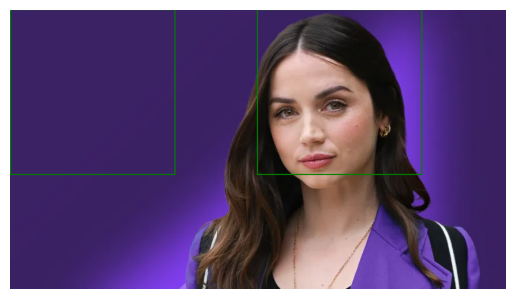

In [ ]:

test_img_path = '/home/marco/Documenti/06 Machine Learning Profession AI - ML Tecniche avanzate/Materiale/Progetto/03.jpg'
test_img = Image.open(test_img_path).convert('L')
test_img_array = np.array(test_img)

detections = sliding_window_face_detection(test_img_array, pipeline.named_steps['svm'])

if len(detections) > 0:
    print("Faces detected at:", detections)
else:
    print("No faces detected.")

result_img = draw_detections(Image.open(test_img_path), detections)
plt.imshow(result_img)
plt.axis('off')
plt.show()

The model has a false positive but this was willingly a didactic test from scratch, without the aim of getting high accuracy, for which other methods are already well published and ready to use.

# 5 - PIPELINE DUMP

In [13]:
joblib.dump(pipeline, 'my_pipeline.joblib')

['my_pipeline.joblib']